# TODO list fra mandag d. 24/4 kl.15:36

Jeg skal fikse/finde ud af hvordna de der k-vektor fungere med class og Kn.

Mit indtryk er at jeg bliver nød til at kalde class rigtig mange mange gange og der lyder lidt uhyggeligt.

Så få fat i Thomas eller Emil.


$\ddot{D}+\mathcal{H}\dot{D}-\frac{3}{2}\frac{H_0^2\Omega_m}{a}D=0$

$(\mathcal{H}\dot{D}D+\ddot{D}D+2\dot{D}^2)b_-+(4D\dot{D}+\mathcal{H}D^2)\dot{b}_-+2D^2\ddot{b}_-=\frac{3}{2}H_0^2 \Omega_m\frac{D^2}{a}$

For now let us assume equilateral configurations, thsi means $k_1\sim k_2 \sim k_3 \rightarrow \hat{k}_1 \cdot\hat{k}_2 = |k|^2 \cos(60^{\circ})=\frac{1}{2}|k|^2 $ 



In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time

cs(1)=0.00019477974533539888


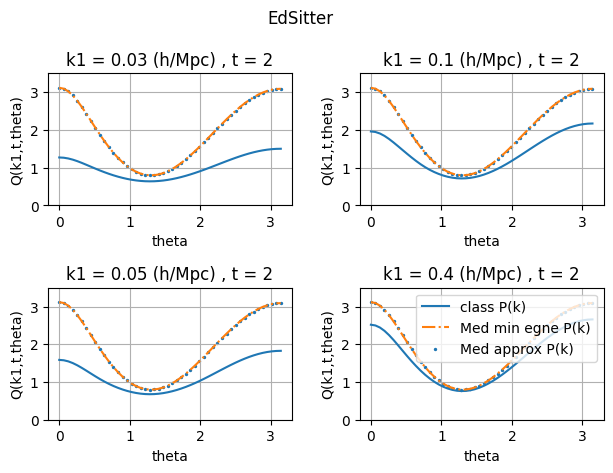

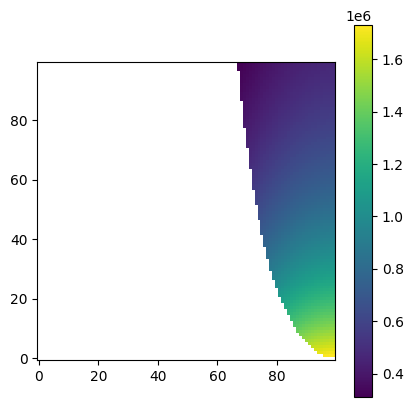

In [141]:
def TEST(kvec=[1],k_ind=0,z=800,mv_test=1 ,   Omega_M = 0.3,Omega_b=0.05,PLOT_FIGUR=True,div_med_a=False,EdSitter=True):

    if EdSitter==True:
        Omega_M = 0.95
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 #,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    tid = bg['proper time [Gyr]'] * c / 306.4 # det kommer af Gyrs * c = 306.4 Mpc
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv

    print(f"{cs(1)=}")
    
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)
    
    
    # henter class data
    #=======================
    delta_test      = np.empty(len(kvec))
    delta_M      = np.empty(len(kvec))
    delta_approx = np.empty(len(kvec))
    
    # her genere 
    for kind,k in enumerate(kvec):
        delta_class = pts[k_ind]["delta_cdm"]
        theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        a_class = pts[k_ind]["a"]
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
        delta_interp = scipy.interpolate.interp1d(tau_class,delta_class)
        theta_interp = scipy.interpolate.interp1d(tau_class,theta_class)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class)
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tau_from_a(a0))
        delta0 = delta_interp(T0)
        t0 = tau_class[-1]
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100)
        def Dfunc(tau,y):
            a = a_interp(tau)
            D = y[0]
            dD = y[1]
            d2D = - H(a) * dD + (3/2) * H0*H0 * Omega_M * D / a
            b = y[2]
            db = y[3]
            d2b = 1/(2*D*D) * (3/2 * H0**2 * Omega_M * D**2 /a - (H(a)*dD*D+d2D*D+2*dD**2)*b - (4*D*dD+H(a)*dD**2)*db)
            return [dD,d2D,db,d2b]

        start0 = [delta_interp(T0),theta_interp(T0),0,0]
        sol = sc.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        D = scipy.interpolate.interp1d(sol.t,-sol.y[0])
        b = scipy.interpolate.interp1d(sol.t,-sol.y[2])
        #t = sol.t
        delta_M[kind] = D(t0)
        #print("D-delta0/a0a = %.2f" %(D(t0)-delta0/a0)) # der var lige lidt forvirring over hvorfor de ligger så tæt 
        # på hinanden så jeg printede forskellen, jeg tror måske der er ngoet fishy men det kna godt være at den er ok
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
        """plt.loglog(sol.t,-sol.y[0])
        plt.loglog(sol.t,delta0/a0 * (1/4 * H0**2 * sol.t**2))
        plt.loglog(tau_class,-delta_class)"""
    
    
    delta_app =  scipy.interpolate.interp1d(kvec,delta_approx)
    p_approx = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    test =  scipy.interpolate.interp1d(kvec,delta_test)
    p_test = lambda k: 2*np.pi**2 * test(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    delta =  scipy.interpolate.interp1d(kvec,delta_M)
    p_min = lambda k: 2*np.pi**2 * delta(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    
    k = np.array(kvec)
    """
    plt.figure(np.random.randint(1,324234))
    plt.loglog(k,np.abs(p_approx(k)-p_min(k))) 
    
    plt.loglog(k,p(k),label="class")
    plt.loglog(k,p_approx(k),label="approx.")
    plt.loglog(k,p_min(k),label="sim")
    plt.loglog(k,p_test(k),label="test")
    plt.legend()"""
    
    # Det der blev gjord for at sikkre at jeg ikke plottede nogle udnerlige transfer funktioner
    
    def K(k1,t,theta,tid = t0):
        k2 = k1 * t
        v = 7/3 * b(tid)
        bn = 1
        an = (7-3*v)/14
        if EdSitter == True: #if Einstein deSitter
            an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
    
    def reduceret_B_spektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p(k1)*p(k2) * K(k1,t,theta)
                    +p(k3)*p(k1) * K(k3,t3,theta3) 
                    +p(k2)*p(k3) * K(k2,t2,theta2)) / (p(k1)*p(k2)+p(k3)*p(k1)+p(k2)*p(k3))
        return res
      
    
    def Q_min(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p_min(k1)*p_min(k2) * K(k1,t,theta)
                    +p_min(k3)*p_min(k1) * K(k3,t3,theta3) 
                    +p_min(k2)*p_min(k3) * K(k2,t2,theta2))/(p_min(k1)*p_min(k2)+p_min(k3)*p_min(k1)+p_min(k2)*p_min(k3))
        return res
    
    def Q_approx(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p_approx(k1)*p_approx(k2) * K(k1,t,theta)
                    +p_approx(k3)*p_approx(k1) * K(k3,t3,theta3) 
                    +p_approx(k2)*p_approx(k3) * K(k2,t2,theta2))/(p_approx(k1)*p_approx(k2)+p_approx(k3)*p_approx(k1)+p_approx(k2)*p_approx(k3))
        return res
        
    def Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3
        res =  2*(p(k1)*p(k2)*K(k1,t,theta) +p(k3)*p(k1)*K(k3,t3,theta3) +p(k2)*p(k3)*K(k2,t2,theta2))
        return res
    
    
    fig = plt.figure(np.random.randint(0,1110000))
    
    ax = fig.subplots(nrows=2, ncols=2)
    #plt.figure(12312312312123)
    if EdSitter == True:
        fig.suptitle("EdSitter")
    else:
        fig.suptitle("Not EdSitter")
    theta = np.linspace(0,np.pi,50)
    #k1 = 0.03 / h
    
    k_list_test = np.array([0.03,0.1,0.05,0.4]) 
    t = 2
    k_i = 0
    for row in ax:
        for col in row:
            k1 = k_list_test[k_i]/h
            col.plot(theta,reduceret_B_spektrum(k1,t,theta),label="class P(k)")     
            col.plot(theta,Q_min(k1,t,theta),"-.",label="Med min egne P(k)")
            col.scatter(theta,Q_approx(k1,t,theta),s=2,label="Med approx P(k)")
            col.set_title("k1 = %s (h/Mpc) , t = %s"% (k_list_test[k_i],t))
            k_i += 1
            
            col.set_xlabel("theta")
            col.set_ylim([0,3.5])
            col.grid()
            col.set_ylabel("Q(k1,t,theta)",rotation=90)
    
    plt.subplots_adjust(top=1.2)
    fig.tight_layout(pad=1.2)
    plt.legend()
    
    
    tol = 1e-3
    n = 100
    mat = np.empty((n,n))
    #print(mat)
    theta_list = np.zeros(n)
    t_list =  np.zeros(n)
    k1 = 0.88
    t = 2
    #print(theta_list)
    for i in range(n):
        for j in range(n):
            t  = 1/2 * ( 1 + i/n)
            #>theta = np.pi /3 + np.pi / 6 * j / n
            theta =np.pi * j/n
            #if theta not in theta_list:
            """if theta_list[j] == 0 and i == 0:
                theta_list[j] = theta"""
            #print(t,theta)
            #if i % 3 == 0:
             #   print(t,np.cos(np.pi-theta))
            if 2 * t * np.cos(np.pi - theta) >= 1:
                mat[i,j] =  Bispektrum(k1,t,theta)
            else:
                mat[i,j]=None
        #list)
    plt.matshow(mat)#,interpolation="spline16")
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
kvec1=list(np.logspace(-4,1,10))
TEST(kvec = kvec1,EdSitter=True)
#TEST(kvec = kvec1,EdSitter=False)

 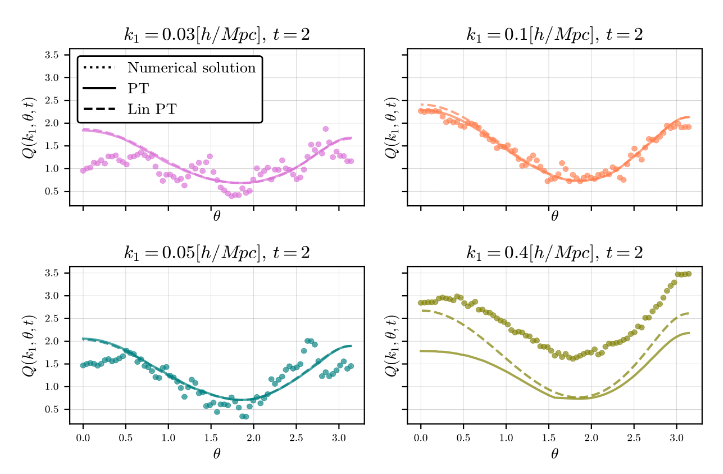

Sjålet fra Johans Speciale

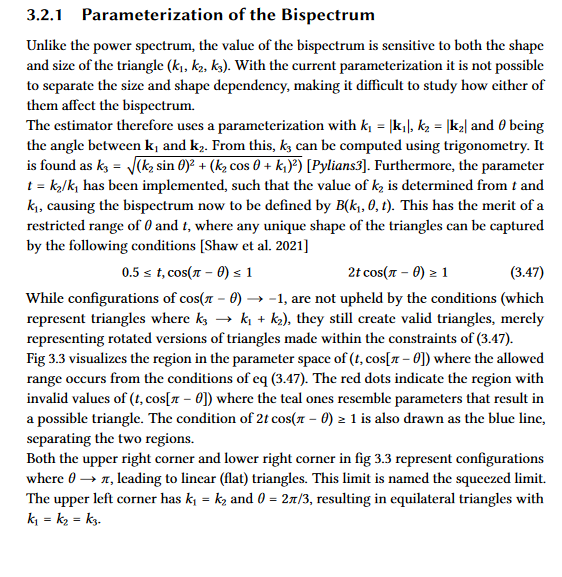

 𝑘3 = √(𝑘2 sin 𝜃)2 + (𝑘2 cos 𝜃 + 𝑘1)2) 

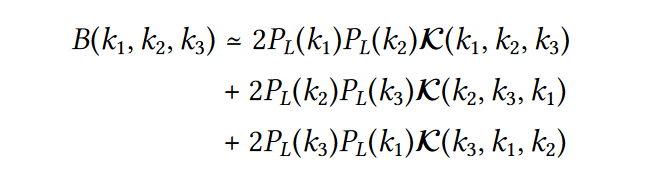

Fra artiklen shaw et al. (Tjek JohaNNS SPECIALE)
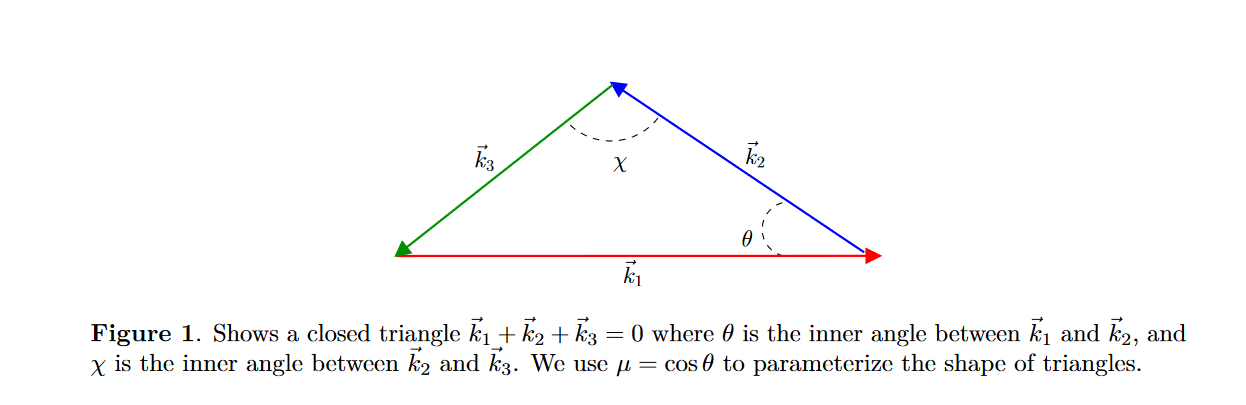


dU BØR NOK SKIMME DENNE ARTIKEL 
https://arxiv.org/abs/2001.10243

'n_list=[0.5,0.6,0.7,0.8,0.9,1]\nxi = list(range(len(n_list)))\nplt.xticks(n_list,xi)'

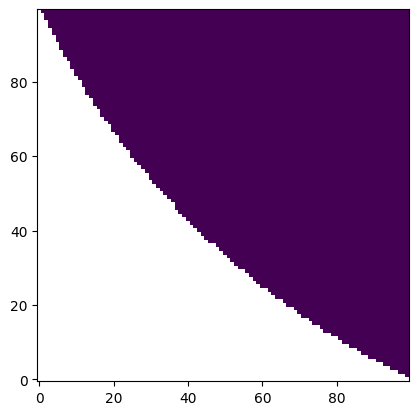

In [6]:
tol = 1e-3
n = 100
mat = np.empty((n,n))
#print(mat)
theta_list = np.zeros(n)
t_list =  np.zeros(n)
k1 = 0.3
#print(theta_list)
for i in range(n):
    for j in range(n):
        t  = 1/2 * ( 1 + i/n)
        #>theta = np.pi /3 + np.pi / 6 * j / n
        theta = np.pi - np.arccos(1/2*( 1 + j/n))
        #if theta not in theta_list:
        """if theta_list[j] == 0 and i == 0:
            theta_list[j] = theta"""
        #print(t,theta)
        #if i % 3 == 0:
         #   print(t,np.cos(np.pi-theta))
        if 2 * t * np.cos(np.pi - theta) >= 1:
            mat[i,j] = 1
        else:
            mat[i,j]=None
#print(theta_list)
plt.matshow(mat)#,interpolation="spline16")
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_bottom()
"""n_list=[0.5,0.6,0.7,0.8,0.9,1]
xi = list(range(len(n_list)))
plt.xticks(n_list,xi)"""

In [ ]:
import matplotlib


In [ ]:
"""import matplotlib.pyplot as plt
import numpy as np

# Create a 2D array of random data
data = np.random.rand(80, 80)

# Plot the data using matshow
plt.matshow(data)

# Set the x-axis tick locations and labels
x_tick_locs = np.arange(0, 81, 3)
x_tick_labels = np.arange(0.5, 1.1, 0.1)
plt.xticks(x_tick_locs, x_tick_labels)

# Show the plot
plt.show()
"""

Jeg vil gerne replikere denne figur fra Shaw_2021 k1 = 0.88 Mpc^-1
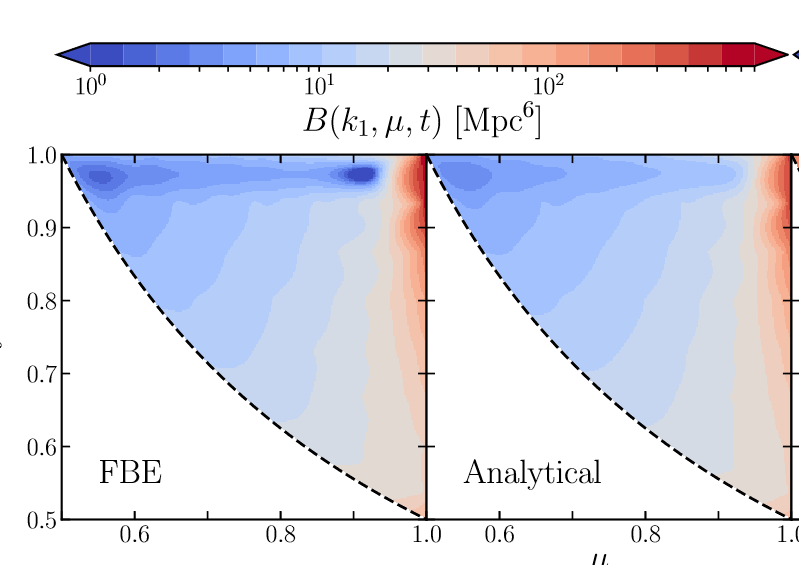

cs(1)=0.00019477974533539888


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


124706.3209776943


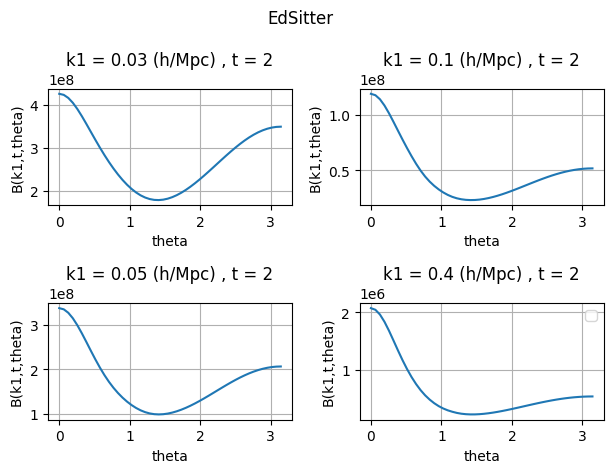

In [136]:
def TEST2(kvec=[1],k_ind=0,z=800,mv_test=1 ,   Omega_M = 0.3,Omega_b=0.05,PLOT_FIGUR=True,div_med_a=False,EdSitter=True):

    if EdSitter==True:
        Omega_M = 0.95
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 #,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    tid = bg['proper time [Gyr]'] * c / 306.4 # det kommer af Gyrs * c = 306.4 Mpc
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv

    print(f"{cs(1)=}")
    
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)
    
    
    # henter class data
    #=======================
    delta_test      = np.empty(len(kvec))
    delta_M      = np.empty(len(kvec))
    delta_approx = np.empty(len(kvec))
    
    # her genere 
    for kind,k in enumerate(kvec):
        delta_class = pts[k_ind]["delta_cdm"]
        theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        a_class = pts[k_ind]["a"]
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
        delta_interp = scipy.interpolate.interp1d(tau_class,delta_class)
        theta_interp = scipy.interpolate.interp1d(tau_class,theta_class)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class)
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tau_from_a(a0))
        delta0 = delta_interp(T0)
        t0 = tau_class[-1]
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100)
        def Dfunc(tau,y):
            a = a_interp(tau)
            D = y[0]
            dD = y[1]
            d2D = - H(a) * dD + (3/2) * H0*H0 * Omega_M * D / a
            b = y[2]
            db = y[3]
            d2b = 1/(2*D*D) * (3/2 * H0**2 * Omega_M * D**2 /a - (H(a)*dD*D+d2D*D+2*dD**2)*b - (4*D*dD+H(a)*dD**2)*db)
            return [dD,d2D,db,d2b]

        start0 = [delta_interp(T0),theta_interp(T0),0,0]
        sol = sc.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        D = scipy.interpolate.interp1d(sol.t,-sol.y[0])
        b = scipy.interpolate.interp1d(sol.t,-sol.y[2])
        #t = sol.t
        delta_M[kind] = D(t0)
        #print("D-delta0/a0a = %.2f" %(D(t0)-delta0/a0)) # der var lige lidt forvirring over hvorfor de ligger så tæt 
        # på hinanden så jeg printede forskellen, jeg tror måske der er ngoet fishy men det kna godt være at den er ok
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
        """plt.loglog(sol.t,-sol.y[0])
        plt.loglog(sol.t,delta0/a0 * (1/4 * H0**2 * sol.t**2))
        plt.loglog(tau_class,-delta_class)"""
    
    
    delta_app =  scipy.interpolate.interp1d(kvec,delta_approx)
    p_approx = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    test =  scipy.interpolate.interp1d(kvec,delta_test)
    p_test = lambda k: 2*np.pi**2 * test(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    delta =  scipy.interpolate.interp1d(kvec,delta_M)
    p_min = lambda k: 2*np.pi**2 * delta(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    
    k = np.array(kvec)
    """
    plt.figure(np.random.randint(1,324234))
    plt.loglog(k,np.abs(p_approx(k)-p_min(k))) 
    
    plt.loglog(k,p(k),label="class")
    plt.loglog(k,p_approx(k),label="approx.")
    plt.loglog(k,p_min(k),label="sim")
    plt.loglog(k,p_test(k),label="test")
    plt.legend()"""
    
    # Det der blev gjord for at sikkre at jeg ikke plottede nogle udnerlige transfer funktioner
    
    def K(k1,t,theta,tid = t0):
        k2 = k1 * t
        v = 7/3 * b(tid)
        bn = 1
        an = (7-3*v)/14
        if EdSitter == True: #if Einstein deSitter
            an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
    
    def reduceret_B_spektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p(k1)*p(k2) * K(k1,t,theta)
                    +p(k3)*p(k1) * K(k3,t3,theta3) 
                    +p(k2)*p(k3) * K(k2,t2,theta2)) / (p(k1)*p(k2)+p(k3)*p(k1)+p(k2)*p(k3))
        return res
      
    
    def Q_min(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p_min(k1)*p_min(k2) * K(k1,t,theta)
                    +p_min(k3)*p_min(k1) * K(k3,t3,theta3) 
                    +p_min(k2)*p_min(k3) * K(k2,t2,theta2))/(p_min(k1)*p_min(k2)+p_min(k3)*p_min(k1)+p_min(k2)*p_min(k3))
        return res
    
    def Q_approx(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p_approx(k1)*p_approx(k2) * K(k1,t,theta)
                    +p_approx(k3)*p_approx(k1) * K(k3,t3,theta3) 
                    +p_approx(k2)*p_approx(k3) * K(k2,t2,theta2))/(p_approx(k1)*p_approx(k2)+p_approx(k3)*p_approx(k1)+p_approx(k2)*p_approx(k3))
        return res
        
    def Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3
        res =  2*(p(k1)*p(k2)*K(k1,t,theta) +p(k3)*p(k1)*K(k3,t3,theta3) +p(k2)*p(k3)*K(k2,t2,theta2))
        return res
    
    
    fig = plt.figure(np.random.randint(0,1110000))
    
    ax = fig.subplots(nrows=2, ncols=2)
    #plt.figure(12312312312123)
    if EdSitter == True:
        fig.suptitle("EdSitter")
    else:
        fig.suptitle("Not EdSitter")
    theta = np.linspace(0,np.pi,50)
    #k1 = 0.03 / h
    
    k_list_test = np.array([0.03,0.1,0.05,0.4]) 
    t = 2
    k_i = 0
    for row in ax:
        for col in row:
            k1 = k_list_test[k_i]/h
            #col.plot(theta,reduceret_B_spektrum(k1,t,theta),label="class P(k)")     
            col.plot(theta,Bispektrum(k1,t,theta))
            #col.plot(theta,Q_min(k1,t,theta),"-.",label="Med min egne P(k)")
            #col.scatter(theta,Q_approx(k1,t,theta),s=2,label="Med approx P(k)")
            col.set_title("k1 = %s (h/Mpc) , t = %s"% (k_list_test[k_i],t))
            k_i += 1
            
            col.set_xlabel("theta")
            #col.set_ylim([0,3.5])
            col.grid()
            col.set_ylabel("B(k1,t,theta)",rotation=90)
    
    plt.subplots_adjust(top=1.2)
    fig.tight_layout(pad=1.2)
    #plt.legend()
    print(Bispektrum(1,1,np.pi/3))
    
kvec1=list(np.logspace(-4,1,10))
TEST2(kvec = kvec1,EdSitter=True)